# Conditional Variational Autoencoders

In this notebook we will build the conditional variation of the autoencoder, train it and analyse the latent space with t-SNE technique.



# The dataset

We will use the MNIST dataset in this notebook.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Training on cuda


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
batch_size = 128
learning_rate = 0.005
input_size = 28*28
hidden_size = 12
labels_length = 10

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
dataset = MNIST('./data', transform=transform, download=True)
train_data, test_data = data.random_split(dataset, (50000,10000))

train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 132777570.62it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44633638.11it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74714698.98it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16324360.56it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
#helper functions
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = matplotlib.cm.binary)
    plt.show()
    
def plot_loss(history):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size + labels_length, 64),
            #nn.ReLU(True),
            #nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_size))
             
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + labels_length, 64),
            nn.ReLU(True),
            #nn.Linear(64, 128),
            #nn.ReLU(True),
            nn.Linear(64, input_size),
            nn.Tanh())

    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x,labels),dim=1)
        return self.encoder(x)
    
    def decode(self, x, labels):
        x = torch.cat((x,labels),dim=1)
        return self.decoder(x)

    def forward(self, x, labels):
        x = self.encode(x,labels)
        x = self.decode(x,labels)
        return x

In [8]:
model = autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer, is_cvae):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)
        optimizer.zero_grad()
        if is_cvae:
            outputs, mu, logvar = model(inputs,labels)
            loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
            loss.backward()
        else:
            outputs = model(inputs,labels)
            loss = criterion(outputs, inputs.view(-1,28*28))
            loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    return train_loss
  
def eval_epoch(model, val_loader, criterion, is_cvae):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    inp,out = [],[]
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        with torch.set_grad_enabled(False):
            if is_cvae:
                outputs, mu, logvar = model(inputs,labels)
                loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
                loss.backward()
            else:
                outputs = model(inputs,labels)
                loss = criterion(outputs, inputs.view(-1,28*28))
                inp,out = inputs, outputs

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
        
    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].cpu(),out[0].cpu()],28,28,1,2)

    val_loss = running_loss / processed_size
    return val_loss
  
def train(train_loader, val_loader, model, epochs, batch_size, is_cvae=False):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:        
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt, is_cvae)
            print("loss", train_loss)            
            val_loss = eval_epoch(model, val_loader, criterion, is_cvae)
            history.append((train_loss, val_loss))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))            
    return history

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

loss 0.1922079206585884


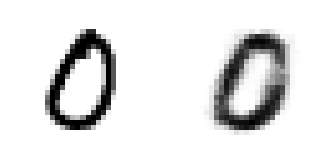

epoch:   0%|          | 1/200 [00:14<47:43, 14.39s/it]


Epoch 001 train_loss: 0.1922 val_loss 0.1186
loss 0.10932358506917954


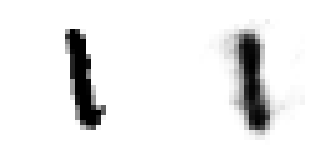

epoch:   1%|          | 2/200 [00:27<44:23, 13.45s/it]


Epoch 002 train_loss: 0.1093 val_loss 0.1036
loss 0.09933730713129044


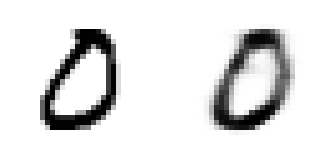

epoch:   2%|▏         | 3/200 [00:39<42:53, 13.06s/it]


Epoch 003 train_loss: 0.0993 val_loss 0.0968
loss 0.09444586796998977


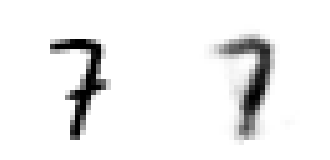

epoch:   2%|▏         | 4/200 [00:52<42:21, 12.97s/it]


Epoch 004 train_loss: 0.0944 val_loss 0.0929
loss 0.09100651455163955


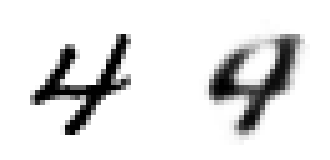

epoch:   2%|▎         | 5/200 [01:05<41:51, 12.88s/it]


Epoch 005 train_loss: 0.0910 val_loss 0.0905
loss 0.08865218564510345


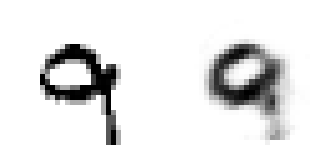

epoch:   3%|▎         | 6/200 [01:18<41:49, 12.94s/it]


Epoch 006 train_loss: 0.0887 val_loss 0.0880
loss 0.08679814654827119


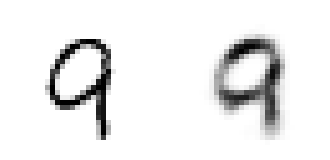

epoch:   4%|▎         | 7/200 [01:30<41:12, 12.81s/it]


Epoch 007 train_loss: 0.0868 val_loss 0.0863
loss 0.08491016729354858


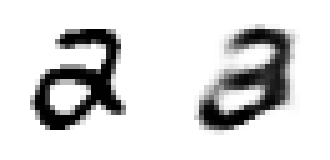

epoch:   4%|▍         | 8/200 [01:43<40:48, 12.76s/it]


Epoch 008 train_loss: 0.0849 val_loss 0.0847
loss 0.08327054481267929


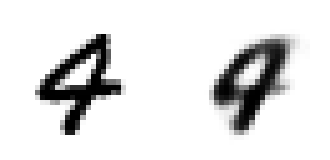

epoch:   4%|▍         | 9/200 [01:56<40:37, 12.76s/it]


Epoch 009 train_loss: 0.0833 val_loss 0.0832
loss 0.0818867883992195


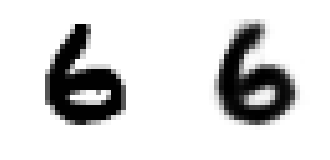

epoch:   5%|▌         | 10/200 [02:08<40:11, 12.69s/it]


Epoch 010 train_loss: 0.0819 val_loss 0.0818
loss 0.08064699161767959


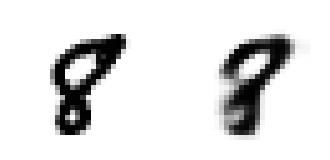

epoch:   6%|▌         | 11/200 [02:21<39:56, 12.68s/it]


Epoch 011 train_loss: 0.0806 val_loss 0.0807
loss 0.07955703917741776


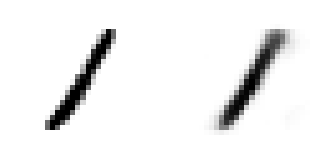

epoch:   6%|▌         | 12/200 [02:34<39:37, 12.65s/it]


Epoch 012 train_loss: 0.0796 val_loss 0.0796
loss 0.07847590999126434


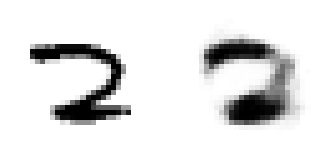

epoch:   6%|▋         | 13/200 [02:46<39:26, 12.66s/it]


Epoch 013 train_loss: 0.0785 val_loss 0.0789
loss 0.07755064983844757


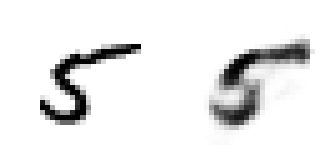

epoch:   7%|▋         | 14/200 [02:59<39:04, 12.61s/it]


Epoch 014 train_loss: 0.0776 val_loss 0.0778
loss 0.07671456764936448


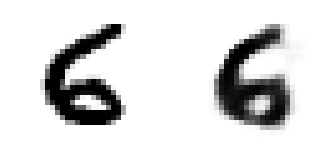

epoch:   8%|▊         | 15/200 [03:12<39:01, 12.66s/it]


Epoch 015 train_loss: 0.0767 val_loss 0.0769
loss 0.07592386162281037


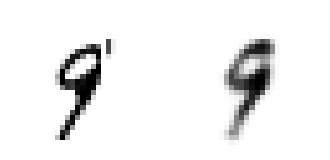

epoch:   8%|▊         | 16/200 [03:24<38:44, 12.63s/it]


Epoch 016 train_loss: 0.0759 val_loss 0.0762
loss 0.07523229179859162


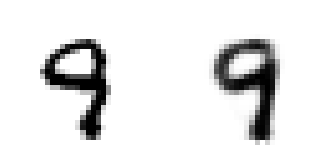

epoch:   8%|▊         | 17/200 [03:37<38:20, 12.57s/it]


Epoch 017 train_loss: 0.0752 val_loss 0.0757
loss 0.07458109285354614


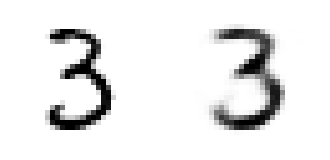

epoch:   9%|▉         | 18/200 [03:49<38:08, 12.57s/it]


Epoch 018 train_loss: 0.0746 val_loss 0.0750
loss 0.0739567168879509


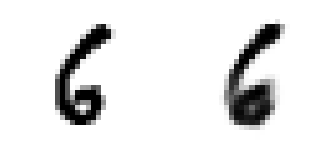

epoch:  10%|▉         | 19/200 [04:02<37:50, 12.54s/it]


Epoch 019 train_loss: 0.0740 val_loss 0.0746
loss 0.07337102940559387


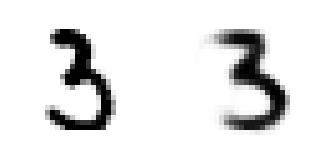

epoch:  10%|█         | 20/200 [04:14<37:30, 12.50s/it]


Epoch 020 train_loss: 0.0734 val_loss 0.0739
loss 0.0728068762755394


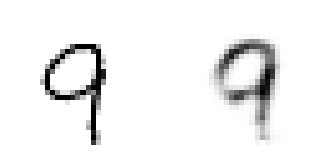

epoch:  10%|█         | 21/200 [04:27<37:31, 12.58s/it]


Epoch 021 train_loss: 0.0728 val_loss 0.0734
loss 0.07237216697216034


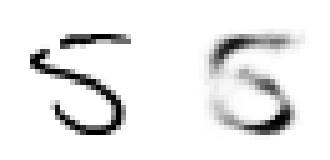

epoch:  11%|█         | 22/200 [04:39<37:07, 12.52s/it]


Epoch 022 train_loss: 0.0724 val_loss 0.0731
loss 0.07184307235240936


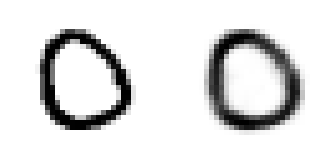

epoch:  12%|█▏        | 23/200 [04:52<37:07, 12.59s/it]


Epoch 023 train_loss: 0.0718 val_loss 0.0724
loss 0.07146228383541108


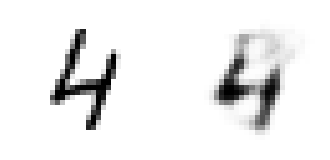

epoch:  12%|█▏        | 24/200 [05:04<36:53, 12.58s/it]


Epoch 024 train_loss: 0.0715 val_loss 0.0722
loss 0.07108750281095505


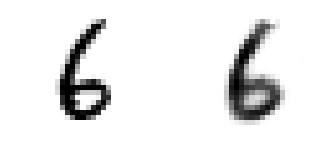

epoch:  12%|█▎        | 25/200 [05:17<36:50, 12.63s/it]


Epoch 025 train_loss: 0.0711 val_loss 0.0717
loss 0.07068585585594177


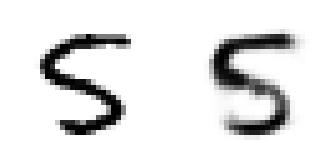

epoch:  13%|█▎        | 26/200 [05:30<36:33, 12.60s/it]


Epoch 026 train_loss: 0.0707 val_loss 0.0713
loss 0.07033738537788391


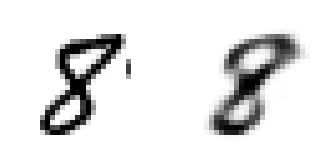

epoch:  14%|█▎        | 27/200 [05:42<36:05, 12.52s/it]


Epoch 027 train_loss: 0.0703 val_loss 0.0709
loss 0.07004860507965088


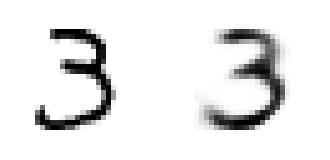

epoch:  14%|█▍        | 28/200 [05:55<36:02, 12.57s/it]


Epoch 028 train_loss: 0.0700 val_loss 0.0708
loss 0.06968031027078629


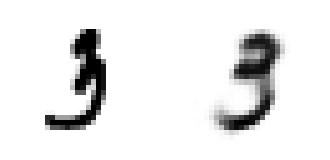

epoch:  14%|█▍        | 29/200 [06:07<35:56, 12.61s/it]


Epoch 029 train_loss: 0.0697 val_loss 0.0703
loss 0.06942272842168808


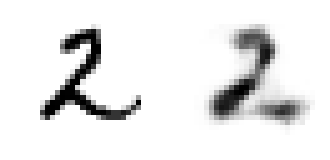

epoch:  15%|█▌        | 30/200 [06:20<35:50, 12.65s/it]


Epoch 030 train_loss: 0.0694 val_loss 0.0704
loss 0.06912180908679962


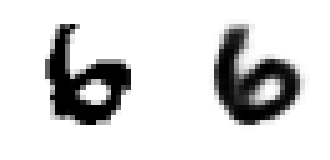

epoch:  16%|█▌        | 31/200 [06:33<35:33, 12.62s/it]


Epoch 031 train_loss: 0.0691 val_loss 0.0700
loss 0.06888336482048035


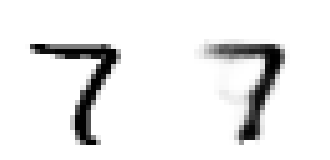

epoch:  16%|█▌        | 32/200 [06:45<35:05, 12.53s/it]


Epoch 032 train_loss: 0.0689 val_loss 0.0697
loss 0.06862336658477783


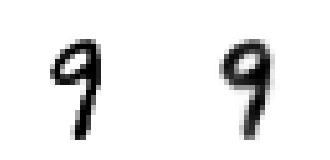

epoch:  16%|█▋        | 33/200 [06:58<35:01, 12.59s/it]


Epoch 033 train_loss: 0.0686 val_loss 0.0697
loss 0.06840016130685807


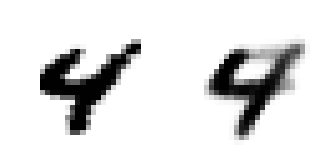

epoch:  17%|█▋        | 34/200 [07:11<34:55, 12.62s/it]


Epoch 034 train_loss: 0.0684 val_loss 0.0690
loss 0.06809790856361389


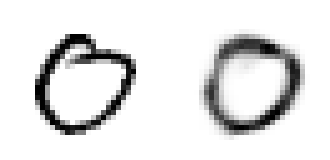

epoch:  18%|█▊        | 35/200 [07:23<34:35, 12.58s/it]


Epoch 035 train_loss: 0.0681 val_loss 0.0690
loss 0.06791417640447617


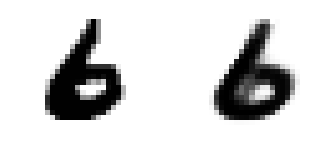

epoch:  18%|█▊        | 36/200 [07:36<34:26, 12.60s/it]


Epoch 036 train_loss: 0.0679 val_loss 0.0688
loss 0.06770697291851044


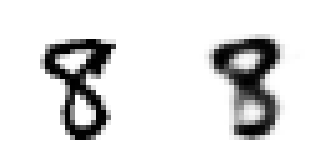

epoch:  18%|█▊        | 37/200 [07:48<34:04, 12.54s/it]


Epoch 037 train_loss: 0.0677 val_loss 0.0687
loss 0.06748087350606918


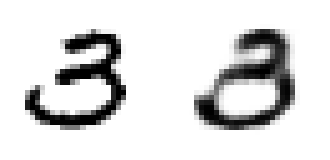

epoch:  19%|█▉        | 38/200 [08:01<33:57, 12.58s/it]


Epoch 038 train_loss: 0.0675 val_loss 0.0683
loss 0.06733407168388367


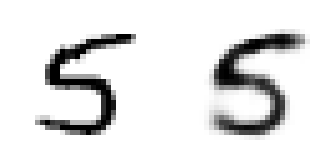

epoch:  20%|█▉        | 39/200 [08:14<34:03, 12.69s/it]


Epoch 039 train_loss: 0.0673 val_loss 0.0682
loss 0.06703458010911942


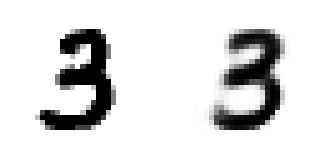

epoch:  20%|██        | 40/200 [08:26<33:48, 12.68s/it]


Epoch 040 train_loss: 0.0670 val_loss 0.0679
loss 0.06687359708547592


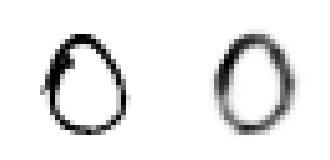

epoch:  20%|██        | 41/200 [08:39<33:38, 12.69s/it]


Epoch 041 train_loss: 0.0669 val_loss 0.0678
loss 0.0666731860423088


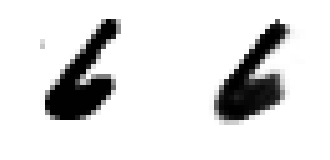

epoch:  21%|██        | 42/200 [08:52<33:22, 12.67s/it]


Epoch 042 train_loss: 0.0667 val_loss 0.0678
loss 0.06645698972225189


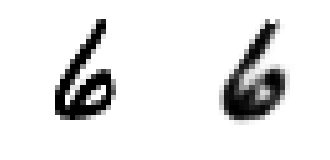

epoch:  22%|██▏       | 43/200 [09:04<33:12, 12.69s/it]


Epoch 043 train_loss: 0.0665 val_loss 0.0672
loss 0.0663111810207367


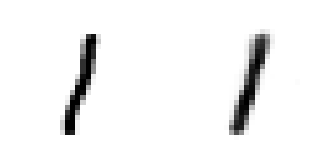

epoch:  22%|██▏       | 44/200 [09:17<32:59, 12.69s/it]


Epoch 044 train_loss: 0.0663 val_loss 0.0671
loss 0.06613145516633988


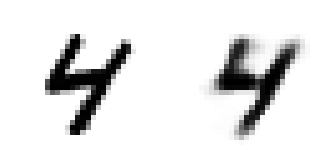

epoch:  22%|██▎       | 45/200 [09:30<32:40, 12.65s/it]


Epoch 045 train_loss: 0.0661 val_loss 0.0672
loss 0.06596488104343415


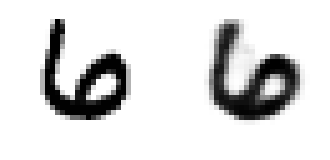

epoch:  23%|██▎       | 46/200 [09:42<32:19, 12.60s/it]


Epoch 046 train_loss: 0.0660 val_loss 0.0667
loss 0.06575381647348404


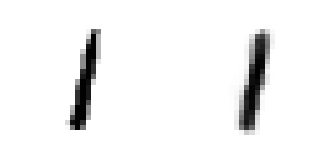

epoch:  24%|██▎       | 47/200 [09:55<32:17, 12.66s/it]


Epoch 047 train_loss: 0.0658 val_loss 0.0668
loss 0.06560832403421402


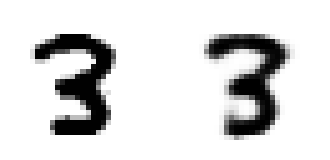

epoch:  24%|██▍       | 48/200 [10:08<32:09, 12.69s/it]


Epoch 048 train_loss: 0.0656 val_loss 0.0665
loss 0.06551532596707343


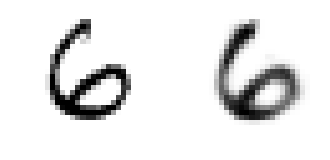

epoch:  24%|██▍       | 49/200 [10:20<32:01, 12.72s/it]


Epoch 049 train_loss: 0.0655 val_loss 0.0664
loss 0.06536779831409455


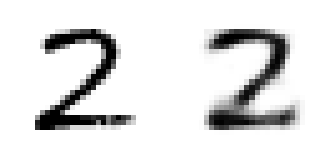

epoch:  25%|██▌       | 50/200 [10:33<31:46, 12.71s/it]


Epoch 050 train_loss: 0.0654 val_loss 0.0661
loss 0.06525244077205658


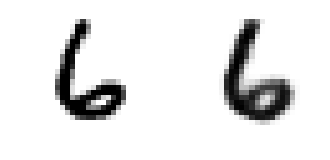

epoch:  26%|██▌       | 51/200 [10:46<31:27, 12.67s/it]


Epoch 051 train_loss: 0.0653 val_loss 0.0662
loss 0.06506511282444


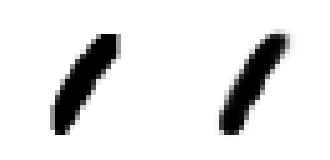

epoch:  26%|██▌       | 52/200 [10:58<31:11, 12.64s/it]


Epoch 052 train_loss: 0.0651 val_loss 0.0659
loss 0.06492429120779038


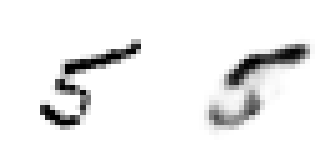

epoch:  26%|██▋       | 53/200 [11:11<31:01, 12.67s/it]


Epoch 053 train_loss: 0.0649 val_loss 0.0660
loss 0.06483974758148194


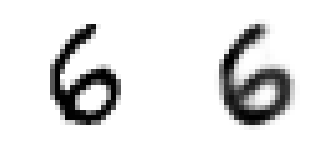

epoch:  27%|██▋       | 54/200 [11:24<30:51, 12.68s/it]


Epoch 054 train_loss: 0.0648 val_loss 0.0657
loss 0.06473959176301956


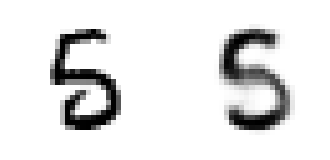

epoch:  28%|██▊       | 55/200 [11:36<30:34, 12.65s/it]


Epoch 055 train_loss: 0.0647 val_loss 0.0656
loss 0.06459912477493286


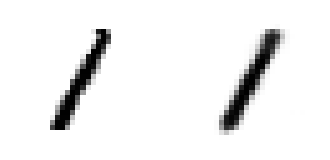

epoch:  28%|██▊       | 56/200 [11:49<30:17, 12.62s/it]


Epoch 056 train_loss: 0.0646 val_loss 0.0658
loss 0.06447246549606324


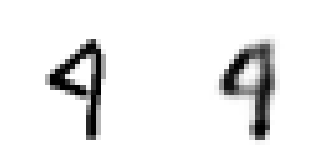

epoch:  28%|██▊       | 57/200 [12:01<30:03, 12.61s/it]


Epoch 057 train_loss: 0.0645 val_loss 0.0654
loss 0.06439101048588752


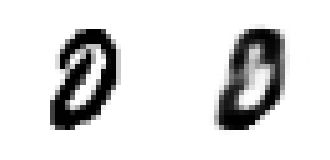

epoch:  29%|██▉       | 58/200 [12:14<29:50, 12.61s/it]


Epoch 058 train_loss: 0.0644 val_loss 0.0651
loss 0.06429490331411361


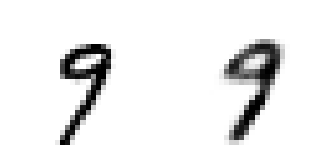

epoch:  30%|██▉       | 59/200 [12:27<29:35, 12.59s/it]


Epoch 059 train_loss: 0.0643 val_loss 0.0655
loss 0.0641547402882576


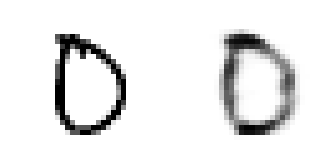

epoch:  30%|███       | 60/200 [12:39<29:22, 12.59s/it]


Epoch 060 train_loss: 0.0642 val_loss 0.0651
loss 0.06407809638977051


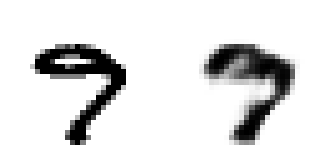

epoch:  30%|███       | 61/200 [12:52<29:14, 12.62s/it]


Epoch 061 train_loss: 0.0641 val_loss 0.0651
loss 0.06397848066806794


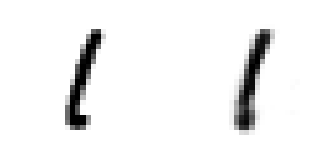

epoch:  31%|███       | 62/200 [13:05<29:01, 12.62s/it]


Epoch 062 train_loss: 0.0640 val_loss 0.0649
loss 0.06387145789146423


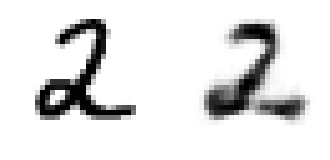

epoch:  32%|███▏      | 63/200 [13:17<28:57, 12.68s/it]


Epoch 063 train_loss: 0.0639 val_loss 0.0648
loss 0.06378002347230911


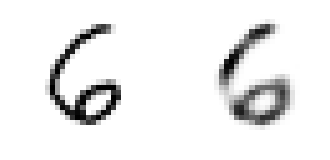

epoch:  32%|███▏      | 64/200 [13:30<28:37, 12.63s/it]


Epoch 064 train_loss: 0.0638 val_loss 0.0647
loss 0.06370710802793503


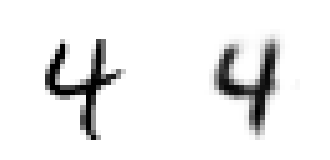

epoch:  32%|███▎      | 65/200 [13:43<28:26, 12.64s/it]


Epoch 065 train_loss: 0.0637 val_loss 0.0646
loss 0.0636214468240738


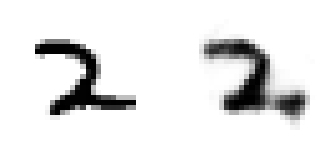

epoch:  33%|███▎      | 66/200 [13:55<28:14, 12.64s/it]


Epoch 066 train_loss: 0.0636 val_loss 0.0646
loss 0.06358584596753121


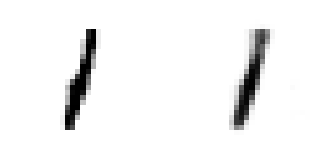

epoch:  34%|███▎      | 67/200 [14:08<27:59, 12.63s/it]


Epoch 067 train_loss: 0.0636 val_loss 0.0644
loss 0.06343367408394814


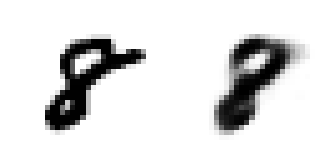

epoch:  34%|███▍      | 68/200 [14:20<27:46, 12.63s/it]


Epoch 068 train_loss: 0.0634 val_loss 0.0644
loss 0.0634263456094265


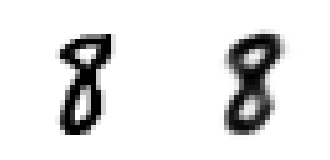

epoch:  34%|███▍      | 69/200 [14:33<27:29, 12.59s/it]


Epoch 069 train_loss: 0.0634 val_loss 0.0644
loss 0.06330352448940277


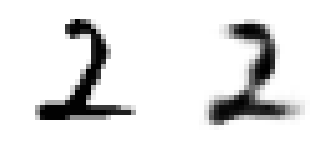

epoch:  35%|███▌      | 70/200 [14:45<27:08, 12.53s/it]


Epoch 070 train_loss: 0.0633 val_loss 0.0644
loss 0.06325676516890526


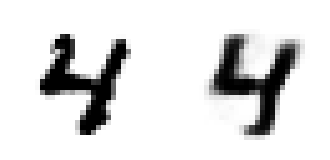

epoch:  36%|███▌      | 71/200 [14:58<27:06, 12.61s/it]


Epoch 071 train_loss: 0.0633 val_loss 0.0643
loss 0.06319012576818467


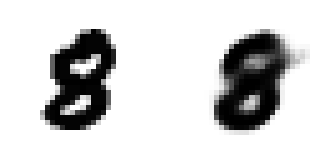

epoch:  36%|███▌      | 72/200 [15:11<26:59, 12.65s/it]


Epoch 072 train_loss: 0.0632 val_loss 0.0639
loss 0.06309507608175277


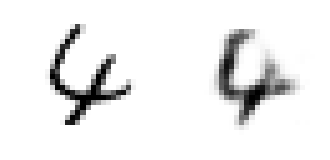

epoch:  36%|███▋      | 73/200 [15:24<26:48, 12.67s/it]


Epoch 073 train_loss: 0.0631 val_loss 0.0641
loss 0.06309485914230346


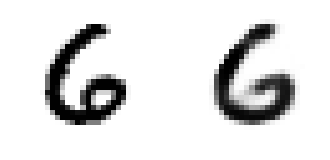

epoch:  37%|███▋      | 74/200 [15:36<26:34, 12.66s/it]


Epoch 074 train_loss: 0.0631 val_loss 0.0640
loss 0.06298648295402527


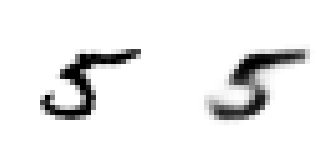

epoch:  38%|███▊      | 75/200 [15:49<26:13, 12.59s/it]


Epoch 075 train_loss: 0.0630 val_loss 0.0643
loss 0.0629646564245224


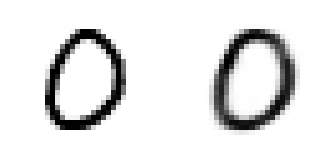

epoch:  38%|███▊      | 76/200 [16:01<25:58, 12.57s/it]


Epoch 076 train_loss: 0.0630 val_loss 0.0639
loss 0.06289559258699418


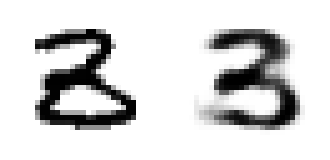

epoch:  38%|███▊      | 77/200 [16:14<25:49, 12.60s/it]


Epoch 077 train_loss: 0.0629 val_loss 0.0638
loss 0.0628256851530075


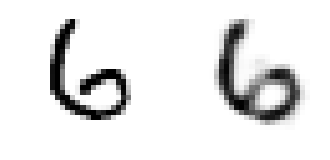

epoch:  39%|███▉      | 78/200 [16:26<25:35, 12.59s/it]


Epoch 078 train_loss: 0.0628 val_loss 0.0638
loss 0.06275383934974671


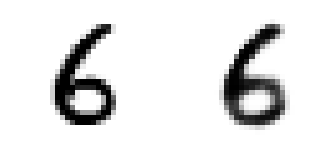

epoch:  40%|███▉      | 79/200 [16:39<25:25, 12.60s/it]


Epoch 079 train_loss: 0.0628 val_loss 0.0638
loss 0.06273423565983773


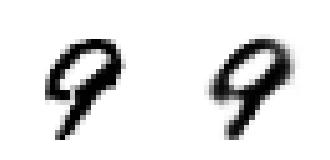

epoch:  40%|████      | 80/200 [16:51<25:07, 12.56s/it]


Epoch 080 train_loss: 0.0627 val_loss 0.0637
loss 0.0626535472035408


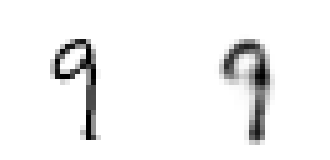

epoch:  40%|████      | 81/200 [17:04<24:53, 12.55s/it]


Epoch 081 train_loss: 0.0627 val_loss 0.0638
loss 0.06259055183649063


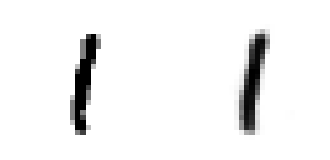

epoch:  41%|████      | 82/200 [17:17<24:54, 12.66s/it]


Epoch 082 train_loss: 0.0626 val_loss 0.0635
loss 0.06256629896402359


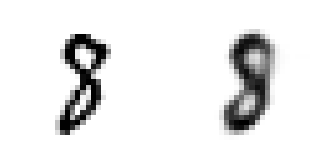

epoch:  42%|████▏     | 83/200 [17:29<24:35, 12.61s/it]


Epoch 083 train_loss: 0.0626 val_loss 0.0636
loss 0.06251327080011368


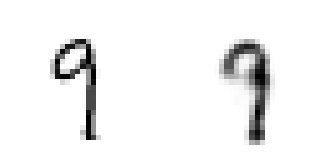

epoch:  42%|████▏     | 84/200 [17:42<24:21, 12.60s/it]


Epoch 084 train_loss: 0.0625 val_loss 0.0636
loss 0.06243676147699356


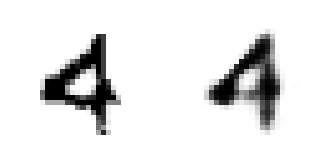

epoch:  42%|████▎     | 85/200 [17:55<24:06, 12.58s/it]


Epoch 085 train_loss: 0.0624 val_loss 0.0634
loss 0.062391910009384155


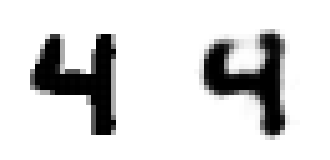

epoch:  43%|████▎     | 86/200 [18:07<23:57, 12.61s/it]


Epoch 086 train_loss: 0.0624 val_loss 0.0634
loss 0.06238969362735748


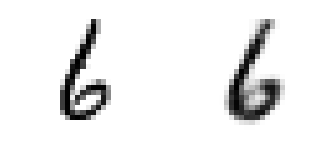

epoch:  44%|████▎     | 87/200 [18:20<23:45, 12.62s/it]


Epoch 087 train_loss: 0.0624 val_loss 0.0634
loss 0.06231902927041054


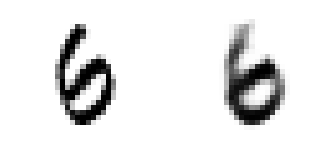

epoch:  44%|████▍     | 88/200 [18:32<23:29, 12.58s/it]


Epoch 088 train_loss: 0.0623 val_loss 0.0633
loss 0.06230928461790085


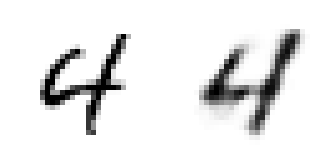

epoch:  44%|████▍     | 89/200 [18:45<23:20, 12.62s/it]


Epoch 089 train_loss: 0.0623 val_loss 0.0636
loss 0.062251880207061766


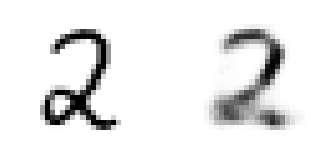

epoch:  45%|████▌     | 90/200 [18:58<23:06, 12.60s/it]


Epoch 090 train_loss: 0.0623 val_loss 0.0631
loss 0.06217975828170776


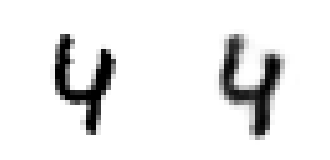

epoch:  46%|████▌     | 91/200 [19:10<22:54, 12.61s/it]


Epoch 091 train_loss: 0.0622 val_loss 0.0635
loss 0.0621524950838089


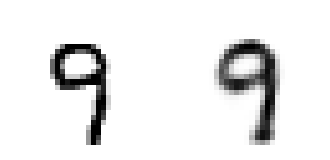

epoch:  46%|████▌     | 92/200 [19:23<22:41, 12.61s/it]


Epoch 092 train_loss: 0.0622 val_loss 0.0631
loss 0.062095431971549986


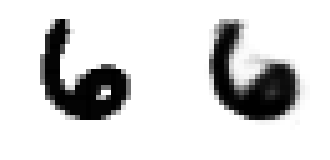

epoch:  46%|████▋     | 93/200 [19:35<22:27, 12.59s/it]


Epoch 093 train_loss: 0.0621 val_loss 0.0631
loss 0.062058025088310244


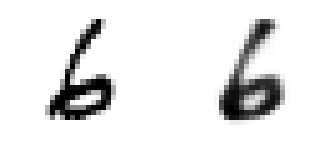

epoch:  47%|████▋     | 94/200 [19:48<22:21, 12.66s/it]


Epoch 094 train_loss: 0.0621 val_loss 0.0634
loss 0.06200266658782959


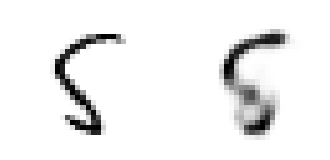

epoch:  48%|████▊     | 95/200 [20:00<21:56, 12.54s/it]


Epoch 095 train_loss: 0.0620 val_loss 0.0631
loss 0.06198753467798233


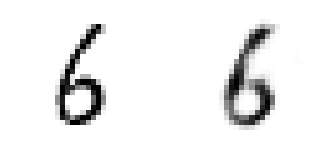

epoch:  48%|████▊     | 96/200 [20:13<21:50, 12.60s/it]


Epoch 096 train_loss: 0.0620 val_loss 0.0630
loss 0.06197655010938644


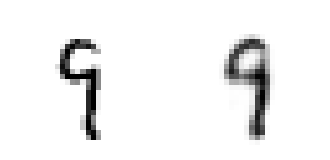

epoch:  48%|████▊     | 97/200 [20:26<21:35, 12.58s/it]


Epoch 097 train_loss: 0.0620 val_loss 0.0629
loss 0.06186757256031036


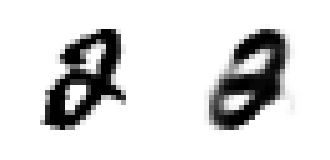

epoch:  49%|████▉     | 98/200 [20:38<21:28, 12.63s/it]


Epoch 098 train_loss: 0.0619 val_loss 0.0630
loss 0.061851966413259504


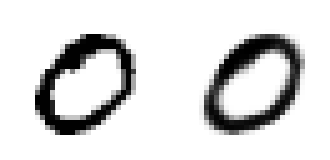

epoch:  50%|████▉     | 99/200 [20:51<21:19, 12.67s/it]


Epoch 099 train_loss: 0.0619 val_loss 0.0628
loss 0.061825822421312335


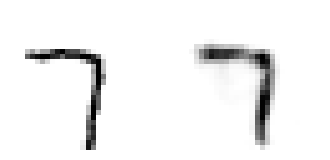

epoch:  50%|█████     | 100/200 [21:04<21:01, 12.62s/it]


Epoch 100 train_loss: 0.0618 val_loss 0.0627
loss 0.06174139931440353


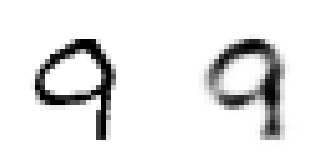

epoch:  50%|█████     | 101/200 [21:16<20:52, 12.65s/it]


Epoch 101 train_loss: 0.0617 val_loss 0.0630
loss 0.06172238979816437


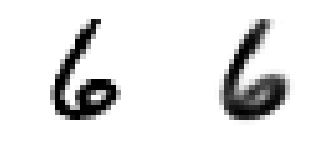

epoch:  51%|█████     | 102/200 [21:29<20:32, 12.58s/it]


Epoch 102 train_loss: 0.0617 val_loss 0.0627
loss 0.0617023909330368


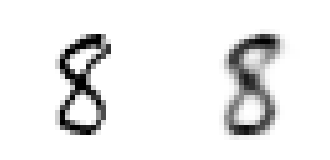

epoch:  52%|█████▏    | 103/200 [21:41<20:16, 12.54s/it]


Epoch 103 train_loss: 0.0617 val_loss 0.0627
loss 0.06163937542796135


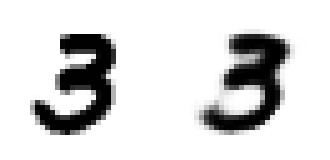

epoch:  52%|█████▏    | 104/200 [21:54<20:10, 12.61s/it]


Epoch 104 train_loss: 0.0616 val_loss 0.0626
loss 0.061601476984024045


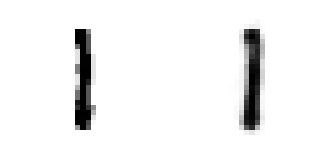

epoch:  52%|█████▎    | 105/200 [22:07<19:55, 12.58s/it]


Epoch 105 train_loss: 0.0616 val_loss 0.0626
loss 0.061550583066940306


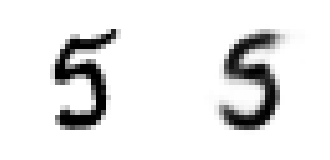

epoch:  53%|█████▎    | 106/200 [22:19<19:44, 12.60s/it]


Epoch 106 train_loss: 0.0616 val_loss 0.0627
loss 0.061559837886095044


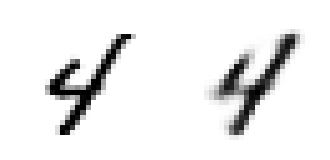

epoch:  54%|█████▎    | 107/200 [22:32<19:26, 12.54s/it]


Epoch 107 train_loss: 0.0616 val_loss 0.0626
loss 0.061492040843963626


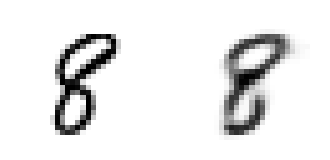

epoch:  54%|█████▍    | 108/200 [22:44<19:10, 12.51s/it]


Epoch 108 train_loss: 0.0615 val_loss 0.0624
loss 0.0614382451236248


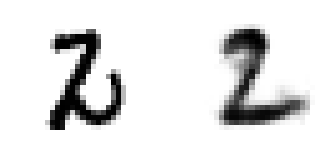

epoch:  55%|█████▍    | 109/200 [22:57<19:03, 12.57s/it]


Epoch 109 train_loss: 0.0614 val_loss 0.0625
loss 0.061425526711940764


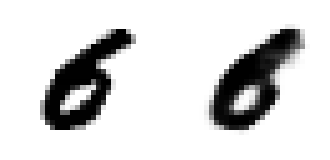

epoch:  55%|█████▌    | 110/200 [23:10<18:57, 12.64s/it]


Epoch 110 train_loss: 0.0614 val_loss 0.0625
loss 0.06138098058104515


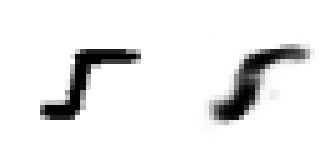

epoch:  56%|█████▌    | 111/200 [23:23<18:51, 12.72s/it]


Epoch 111 train_loss: 0.0614 val_loss 0.0623
loss 0.06129407551050186


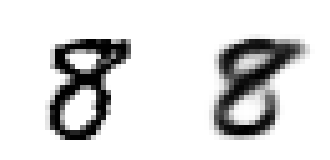

epoch:  56%|█████▌    | 112/200 [23:35<18:33, 12.65s/it]


Epoch 112 train_loss: 0.0613 val_loss 0.0625
loss 0.06133192147731781


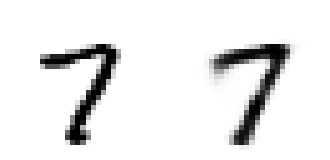

epoch:  56%|█████▋    | 113/200 [23:48<18:22, 12.67s/it]


Epoch 113 train_loss: 0.0613 val_loss 0.0624
loss 0.06124853245973587


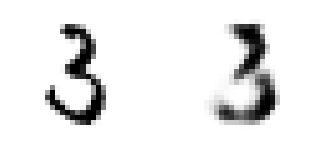

epoch:  57%|█████▋    | 114/200 [24:00<18:03, 12.59s/it]


Epoch 114 train_loss: 0.0612 val_loss 0.0624
loss 0.06116889613032341


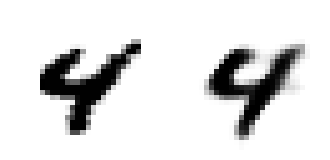

epoch:  57%|█████▊    | 115/200 [24:13<17:48, 12.57s/it]


Epoch 115 train_loss: 0.0612 val_loss 0.0622
loss 0.06117102563023567


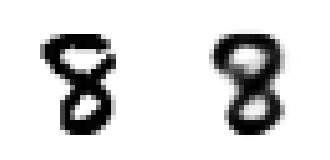

epoch:  58%|█████▊    | 116/200 [24:25<17:41, 12.64s/it]


Epoch 116 train_loss: 0.0612 val_loss 0.0622
loss 0.06107449046373367


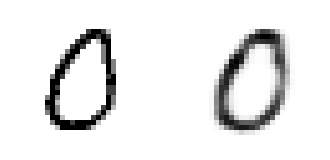

epoch:  58%|█████▊    | 117/200 [24:38<17:22, 12.56s/it]


Epoch 117 train_loss: 0.0611 val_loss 0.0623
loss 0.06108480356693268


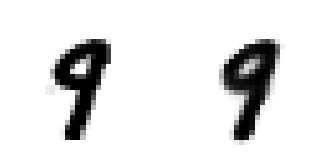

epoch:  59%|█████▉    | 118/200 [24:51<17:13, 12.60s/it]


Epoch 118 train_loss: 0.0611 val_loss 0.0622
loss 0.061040392651557925


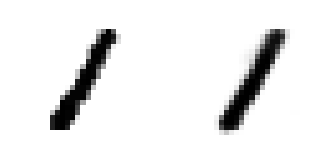

epoch:  60%|█████▉    | 119/200 [25:03<16:56, 12.54s/it]


Epoch 119 train_loss: 0.0610 val_loss 0.0620
loss 0.06099784686803818


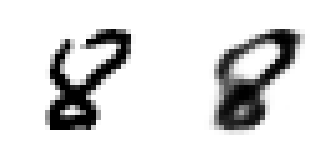

epoch:  60%|██████    | 120/200 [25:16<16:43, 12.55s/it]


Epoch 120 train_loss: 0.0610 val_loss 0.0621
loss 0.060924167680740354


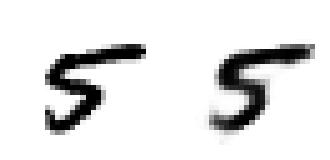

epoch:  60%|██████    | 121/200 [25:28<16:37, 12.63s/it]


Epoch 121 train_loss: 0.0609 val_loss 0.0619
loss 0.06091731064558029


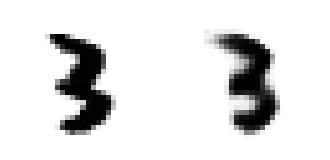

epoch:  61%|██████    | 122/200 [25:41<16:15, 12.51s/it]


Epoch 122 train_loss: 0.0609 val_loss 0.0620
loss 0.06089015064120293


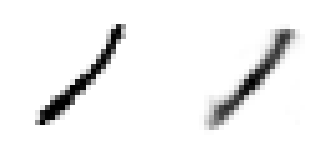

epoch:  62%|██████▏   | 123/200 [25:53<16:00, 12.48s/it]


Epoch 123 train_loss: 0.0609 val_loss 0.0621
loss 0.060850110582113266


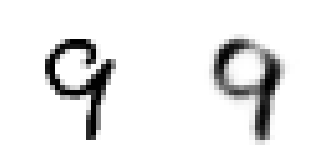

epoch:  62%|██████▏   | 124/200 [26:05<15:43, 12.42s/it]


Epoch 124 train_loss: 0.0609 val_loss 0.0624
loss 0.06085362983226776


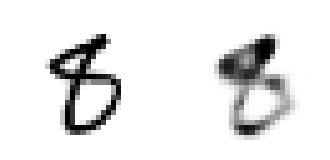

epoch:  62%|██████▎   | 125/200 [26:18<15:32, 12.44s/it]


Epoch 125 train_loss: 0.0609 val_loss 0.0619
loss 0.060766552288532255


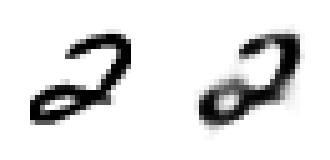

epoch:  63%|██████▎   | 126/200 [26:30<15:17, 12.40s/it]


Epoch 126 train_loss: 0.0608 val_loss 0.0619
loss 0.06079256130218506


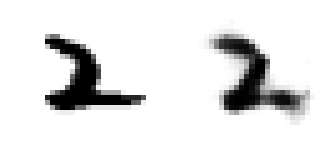

epoch:  64%|██████▎   | 127/200 [26:42<15:02, 12.37s/it]


Epoch 127 train_loss: 0.0608 val_loss 0.0620
loss 0.06070873193025589


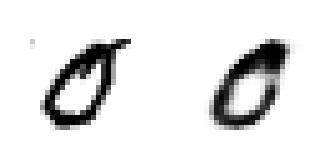

epoch:  64%|██████▍   | 128/200 [26:55<14:51, 12.38s/it]


Epoch 128 train_loss: 0.0607 val_loss 0.0619
loss 0.06068896912455559


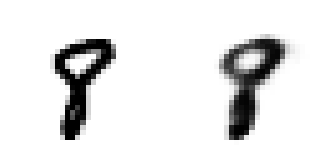

epoch:  64%|██████▍   | 129/200 [27:07<14:40, 12.40s/it]


Epoch 129 train_loss: 0.0607 val_loss 0.0619
loss 0.060680959221124646


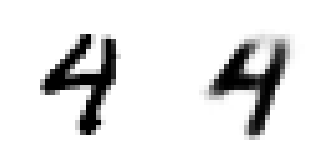

epoch:  65%|██████▌   | 130/200 [27:20<14:27, 12.39s/it]


Epoch 130 train_loss: 0.0607 val_loss 0.0619
loss 0.06063580380558967


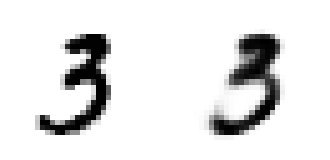

epoch:  66%|██████▌   | 131/200 [27:32<14:21, 12.48s/it]


Epoch 131 train_loss: 0.0606 val_loss 0.0619
loss 0.06059185149431229


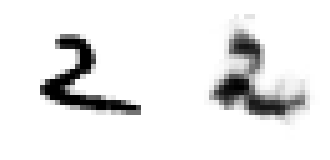

epoch:  66%|██████▌   | 132/200 [27:45<14:07, 12.47s/it]


Epoch 132 train_loss: 0.0606 val_loss 0.0617
loss 0.06055811912536621


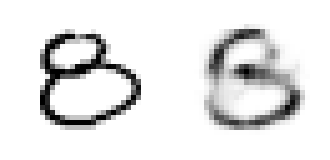

epoch:  66%|██████▋   | 133/200 [27:57<13:52, 12.43s/it]


Epoch 133 train_loss: 0.0606 val_loss 0.0614
loss 0.06053460615158081


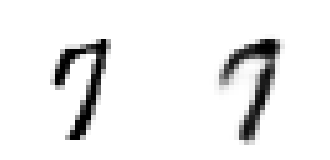

epoch:  67%|██████▋   | 134/200 [28:10<13:42, 12.46s/it]


Epoch 134 train_loss: 0.0605 val_loss 0.0617
loss 0.06047093965530396


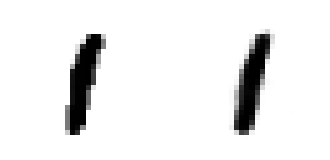

epoch:  68%|██████▊   | 135/200 [28:22<13:27, 12.42s/it]


Epoch 135 train_loss: 0.0605 val_loss 0.0618
loss 0.06048218730211258


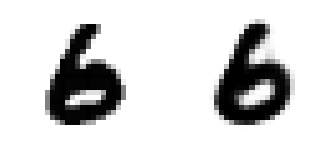

epoch:  68%|██████▊   | 136/200 [28:34<13:14, 12.41s/it]


Epoch 136 train_loss: 0.0605 val_loss 0.0615
loss 0.06046795650482178


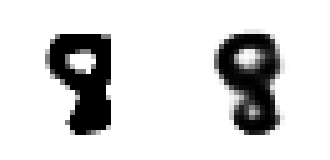

epoch:  68%|██████▊   | 137/200 [28:47<13:10, 12.54s/it]


Epoch 137 train_loss: 0.0605 val_loss 0.0617
loss 0.06041591630458832


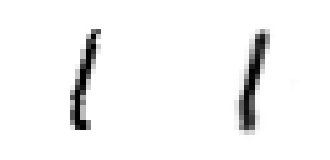

epoch:  69%|██████▉   | 138/200 [29:00<12:59, 12.57s/it]


Epoch 138 train_loss: 0.0604 val_loss 0.0618
loss 0.0603541437625885


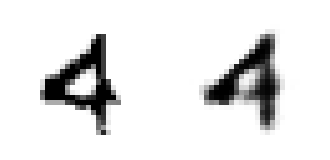

epoch:  70%|██████▉   | 139/200 [29:12<12:45, 12.55s/it]


Epoch 139 train_loss: 0.0604 val_loss 0.0616
loss 0.06036063306093216


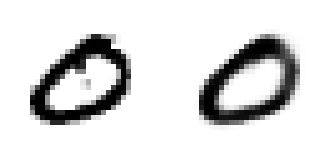

epoch:  70%|███████   | 140/200 [29:25<12:34, 12.58s/it]


Epoch 140 train_loss: 0.0604 val_loss 0.0617
loss 0.060348671699762345


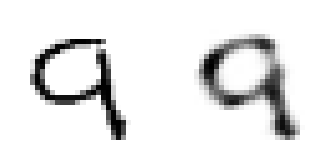

epoch:  70%|███████   | 141/200 [29:37<12:21, 12.57s/it]


Epoch 141 train_loss: 0.0603 val_loss 0.0614
loss 0.06031019241333008


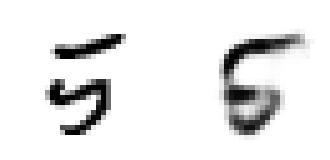

epoch:  71%|███████   | 142/200 [29:50<12:10, 12.59s/it]


Epoch 142 train_loss: 0.0603 val_loss 0.0616
loss 0.060268012974262236


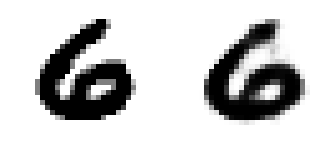

epoch:  72%|███████▏  | 143/200 [30:03<11:56, 12.57s/it]


Epoch 143 train_loss: 0.0603 val_loss 0.0614
loss 0.06022902892112732


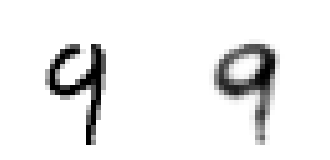

epoch:  72%|███████▏  | 144/200 [30:15<11:45, 12.60s/it]


Epoch 144 train_loss: 0.0602 val_loss 0.0614
loss 0.0602039984190464


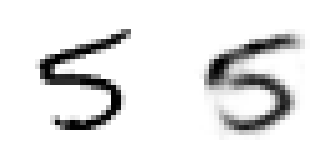

epoch:  72%|███████▎  | 145/200 [30:28<11:35, 12.65s/it]


Epoch 145 train_loss: 0.0602 val_loss 0.0614
loss 0.06019833079338074


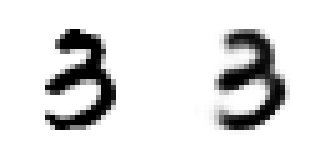

epoch:  73%|███████▎  | 146/200 [30:40<11:18, 12.56s/it]


Epoch 146 train_loss: 0.0602 val_loss 0.0616
loss 0.06014576517224312


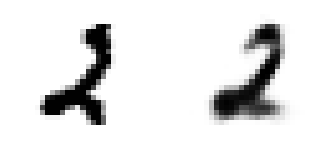

epoch:  74%|███████▎  | 147/200 [30:53<11:02, 12.50s/it]


Epoch 147 train_loss: 0.0601 val_loss 0.0616
loss 0.060091585476398465


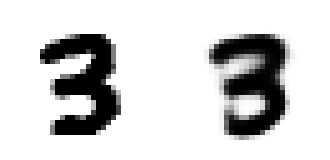

epoch:  74%|███████▍  | 148/200 [31:05<10:52, 12.54s/it]


Epoch 148 train_loss: 0.0601 val_loss 0.0614
loss 0.06007175901293755


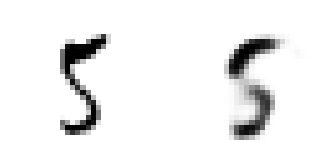

epoch:  74%|███████▍  | 149/200 [31:18<10:36, 12.49s/it]


Epoch 149 train_loss: 0.0601 val_loss 0.0612
loss 0.05999585901737213


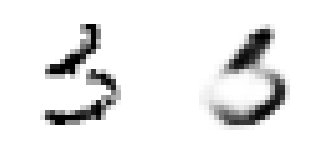

epoch:  75%|███████▌  | 150/200 [31:30<10:27, 12.54s/it]


Epoch 150 train_loss: 0.0600 val_loss 0.0612
loss 0.06005227841615677


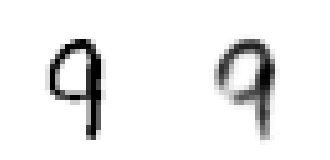

epoch:  76%|███████▌  | 151/200 [31:43<10:13, 12.51s/it]


Epoch 151 train_loss: 0.0601 val_loss 0.0612
loss 0.060049961191415785


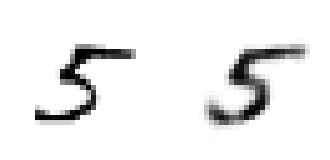

epoch:  76%|███████▌  | 152/200 [31:55<09:55, 12.41s/it]


Epoch 152 train_loss: 0.0600 val_loss 0.0612
loss 0.059992859860658644


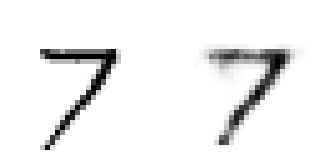

epoch:  76%|███████▋  | 153/200 [32:07<09:43, 12.41s/it]


Epoch 153 train_loss: 0.0600 val_loss 0.0612
loss 0.0600175339782238


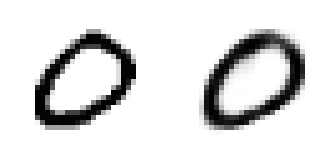

epoch:  77%|███████▋  | 154/200 [32:20<09:29, 12.38s/it]


Epoch 154 train_loss: 0.0600 val_loss 0.0613
loss 0.05993959137916565


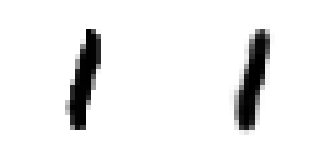

epoch:  78%|███████▊  | 155/200 [32:32<09:16, 12.36s/it]


Epoch 155 train_loss: 0.0599 val_loss 0.0614
loss 0.059899056060314176


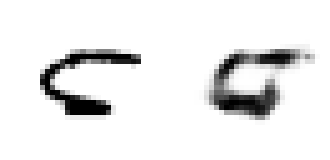

epoch:  78%|███████▊  | 156/200 [32:44<09:02, 12.34s/it]


Epoch 156 train_loss: 0.0599 val_loss 0.0612
loss 0.059874576205015184


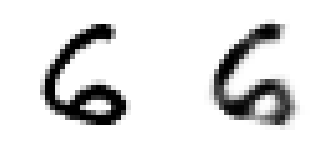

epoch:  78%|███████▊  | 157/200 [32:57<08:49, 12.32s/it]


Epoch 157 train_loss: 0.0599 val_loss 0.0610
loss 0.059843556772470476


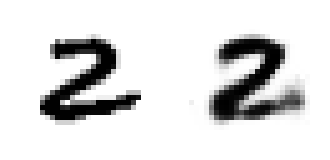

epoch:  79%|███████▉  | 158/200 [33:09<08:41, 12.41s/it]


Epoch 158 train_loss: 0.0598 val_loss 0.0610
loss 0.05985763794660568


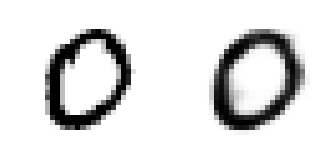

epoch:  80%|███████▉  | 159/200 [33:22<08:28, 12.39s/it]


Epoch 159 train_loss: 0.0599 val_loss 0.0613
loss 0.059807471957206725


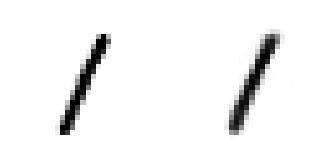

epoch:  80%|████████  | 160/200 [33:34<08:17, 12.43s/it]


Epoch 160 train_loss: 0.0598 val_loss 0.0610
loss 0.059749929163455964


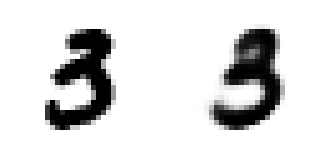

epoch:  80%|████████  | 161/200 [33:47<08:06, 12.48s/it]


Epoch 161 train_loss: 0.0597 val_loss 0.0612
loss 0.05974035210609436


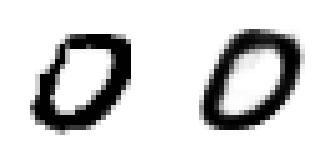

epoch:  81%|████████  | 162/200 [33:59<07:53, 12.45s/it]


Epoch 162 train_loss: 0.0597 val_loss 0.0612
loss 0.05971379220962524


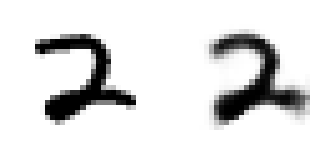

epoch:  82%|████████▏ | 163/200 [34:12<07:44, 12.56s/it]


Epoch 163 train_loss: 0.0597 val_loss 0.0611
loss 0.05970151459217071


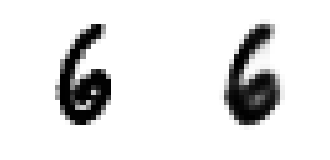

epoch:  82%|████████▏ | 164/200 [34:25<07:33, 12.60s/it]


Epoch 164 train_loss: 0.0597 val_loss 0.0610
loss 0.05967113196015358


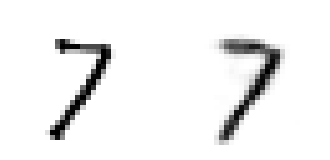

epoch:  82%|████████▎ | 165/200 [34:38<07:31, 12.90s/it]


Epoch 165 train_loss: 0.0597 val_loss 0.0612
loss 0.059663171099424366


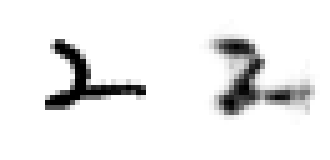

epoch:  83%|████████▎ | 166/200 [34:51<07:21, 12.98s/it]


Epoch 166 train_loss: 0.0597 val_loss 0.0609
loss 0.05964931799411774


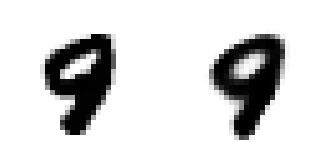

epoch:  84%|████████▎ | 167/200 [35:04<07:08, 13.00s/it]


Epoch 167 train_loss: 0.0596 val_loss 0.0609
loss 0.059587093503475186


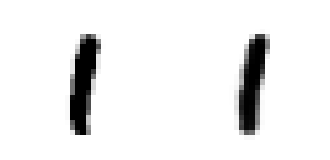

epoch:  84%|████████▍ | 168/200 [35:18<06:58, 13.07s/it]


Epoch 168 train_loss: 0.0596 val_loss 0.0609
loss 0.05956955766201019


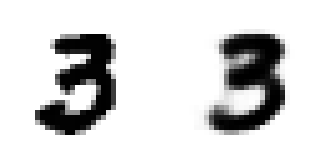

epoch:  84%|████████▍ | 169/200 [35:30<06:41, 12.97s/it]


Epoch 169 train_loss: 0.0596 val_loss 0.0608
loss 0.05955214927315712


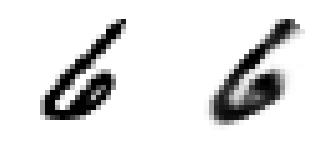

epoch:  85%|████████▌ | 170/200 [35:43<06:26, 12.88s/it]


Epoch 170 train_loss: 0.0596 val_loss 0.0608
loss 0.05954433212041855


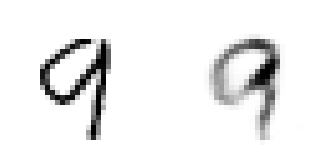

epoch:  86%|████████▌ | 171/200 [35:56<06:12, 12.85s/it]


Epoch 171 train_loss: 0.0595 val_loss 0.0610
loss 0.05950107695102692


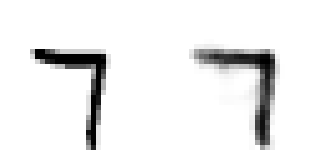

epoch:  86%|████████▌ | 172/200 [36:09<06:00, 12.86s/it]


Epoch 172 train_loss: 0.0595 val_loss 0.0607
loss 0.059474437936544416


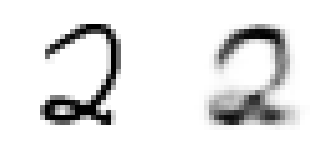

epoch:  86%|████████▋ | 173/200 [36:21<05:44, 12.74s/it]


Epoch 173 train_loss: 0.0595 val_loss 0.0607
loss 0.05945540905356407


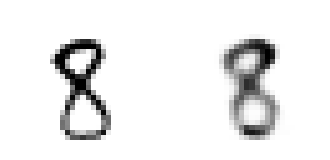

epoch:  87%|████████▋ | 174/200 [36:34<05:29, 12.69s/it]


Epoch 174 train_loss: 0.0595 val_loss 0.0608
loss 0.0593681021630764


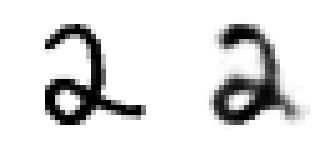

epoch:  88%|████████▊ | 175/200 [36:46<05:15, 12.60s/it]


Epoch 175 train_loss: 0.0594 val_loss 0.0607
loss 0.05936239040851593


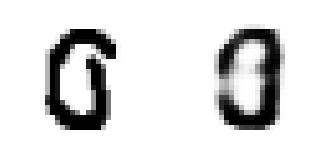

epoch:  88%|████████▊ | 176/200 [36:59<05:01, 12.57s/it]


Epoch 176 train_loss: 0.0594 val_loss 0.0604
loss 0.059343834348917004


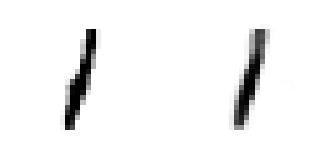

epoch:  88%|████████▊ | 177/200 [37:11<04:48, 12.54s/it]


Epoch 177 train_loss: 0.0593 val_loss 0.0604
loss 0.05928767895460129


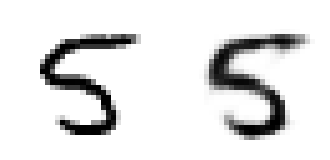

epoch:  89%|████████▉ | 178/200 [37:24<04:35, 12.51s/it]


Epoch 178 train_loss: 0.0593 val_loss 0.0605
loss 0.059282044011354444


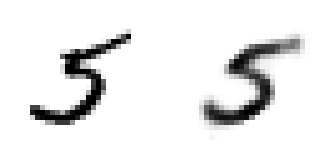

epoch:  90%|████████▉ | 179/200 [37:36<04:22, 12.51s/it]


Epoch 179 train_loss: 0.0593 val_loss 0.0608
loss 0.0592688803768158


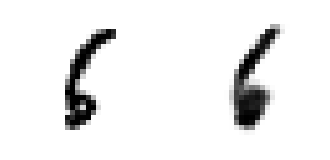

epoch:  90%|█████████ | 180/200 [37:48<04:09, 12.46s/it]


Epoch 180 train_loss: 0.0593 val_loss 0.0605
loss 0.059248713927268985


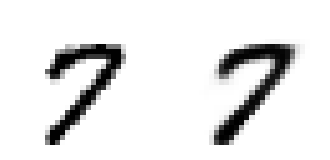

epoch:  90%|█████████ | 181/200 [38:01<03:56, 12.42s/it]


Epoch 181 train_loss: 0.0592 val_loss 0.0606
loss 0.05914226753115654


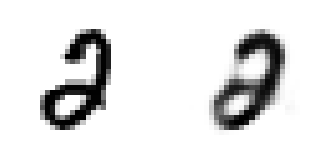

epoch:  91%|█████████ | 182/200 [38:13<03:45, 12.50s/it]


Epoch 182 train_loss: 0.0591 val_loss 0.0607
loss 0.059168468542099


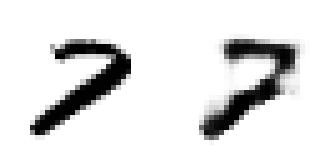

epoch:  92%|█████████▏| 183/200 [38:26<03:32, 12.49s/it]


Epoch 183 train_loss: 0.0592 val_loss 0.0605
loss 0.059145360268354416


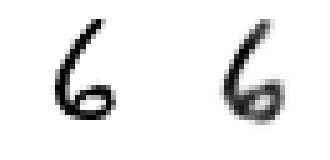

epoch:  92%|█████████▏| 184/200 [38:38<03:19, 12.47s/it]


Epoch 184 train_loss: 0.0591 val_loss 0.0605
loss 0.059165551077127454


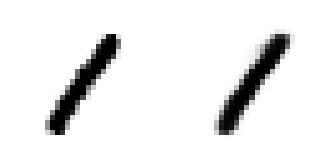

epoch:  92%|█████████▎| 185/200 [38:51<03:06, 12.41s/it]


Epoch 185 train_loss: 0.0592 val_loss 0.0604
loss 0.059134638600349426


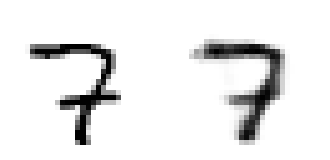

epoch:  93%|█████████▎| 186/200 [39:03<02:53, 12.37s/it]


Epoch 186 train_loss: 0.0591 val_loss 0.0603
loss 0.05904816460609436


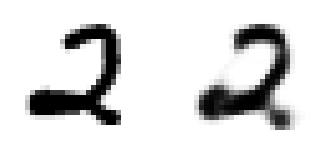

epoch:  94%|█████████▎| 187/200 [39:15<02:41, 12.39s/it]


Epoch 187 train_loss: 0.0590 val_loss 0.0604
loss 0.05902648855686188


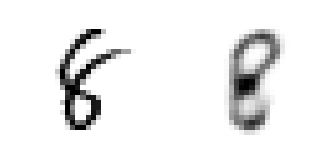

epoch:  94%|█████████▍| 188/200 [39:28<02:28, 12.38s/it]


Epoch 188 train_loss: 0.0590 val_loss 0.0602
loss 0.05899726223230362


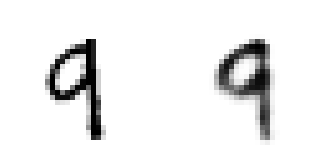

epoch:  94%|█████████▍| 189/200 [39:40<02:16, 12.39s/it]


Epoch 189 train_loss: 0.0590 val_loss 0.0602
loss 0.05898515897750854


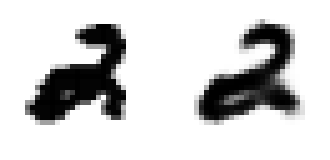

epoch:  95%|█████████▌| 190/200 [39:53<02:04, 12.42s/it]


Epoch 190 train_loss: 0.0590 val_loss 0.0603
loss 0.058991405159235004


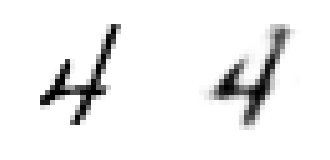

epoch:  96%|█████████▌| 191/200 [40:05<01:52, 12.47s/it]


Epoch 191 train_loss: 0.0590 val_loss 0.0603
loss 0.05891058561205864


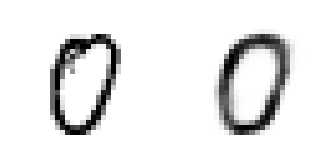

epoch:  96%|█████████▌| 192/200 [40:18<01:40, 12.51s/it]


Epoch 192 train_loss: 0.0589 val_loss 0.0605
loss 0.05894499525547028


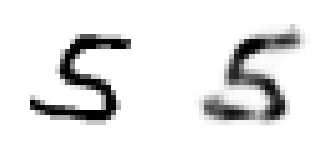

epoch:  96%|█████████▋| 193/200 [40:30<01:27, 12.44s/it]


Epoch 193 train_loss: 0.0589 val_loss 0.0602
loss 0.05890340893983841


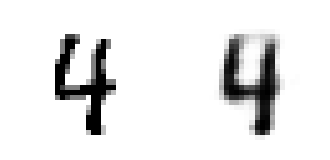

epoch:  97%|█████████▋| 194/200 [40:42<01:14, 12.45s/it]


Epoch 194 train_loss: 0.0589 val_loss 0.0604
loss 0.05886356977939606


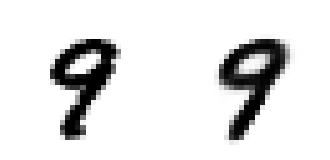

epoch:  98%|█████████▊| 195/200 [40:55<01:02, 12.54s/it]


Epoch 195 train_loss: 0.0589 val_loss 0.0605
loss 0.05886423724532128


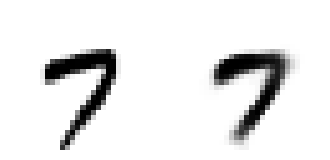

epoch:  98%|█████████▊| 196/200 [41:08<00:50, 12.61s/it]


Epoch 196 train_loss: 0.0589 val_loss 0.0603
loss 0.05887424066185951


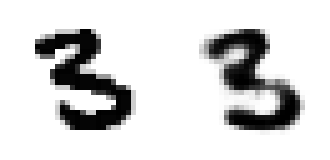

epoch:  98%|█████████▊| 197/200 [41:20<00:37, 12.55s/it]


Epoch 197 train_loss: 0.0589 val_loss 0.0602
loss 0.058793001335859296


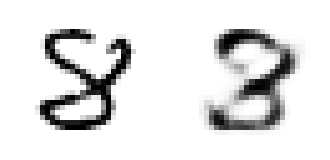

epoch:  99%|█████████▉| 198/200 [41:33<00:25, 12.54s/it]


Epoch 198 train_loss: 0.0588 val_loss 0.0602
loss 0.05876857733011246


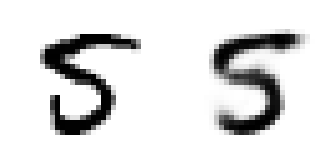

epoch: 100%|█████████▉| 199/200 [41:45<00:12, 12.54s/it]


Epoch 199 train_loss: 0.0588 val_loss 0.0602
loss 0.05880953512191772


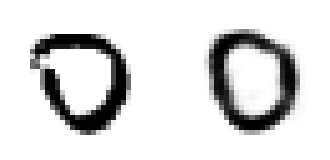

epoch: 100%|██████████| 200/200 [41:58<00:00, 12.59s/it]


Epoch 200 train_loss: 0.0588 val_loss 0.0604


In [10]:
history = train(train_dataset, val_dataset, model=model, epochs=200, batch_size=64, is_cvae=False)

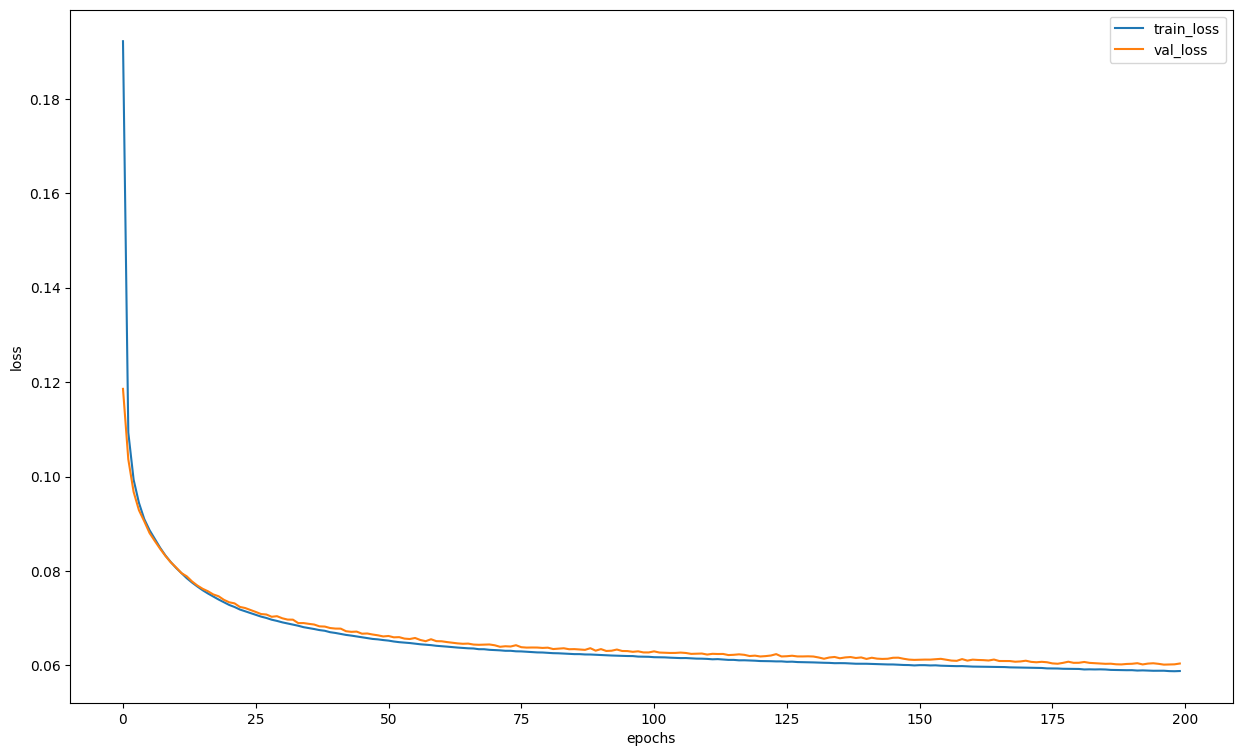

In [11]:
plot_loss(history)

# Sampling

We can try to get the numbers we want to generate, instead of random pictures. Let's say numbers from 0 to 9.

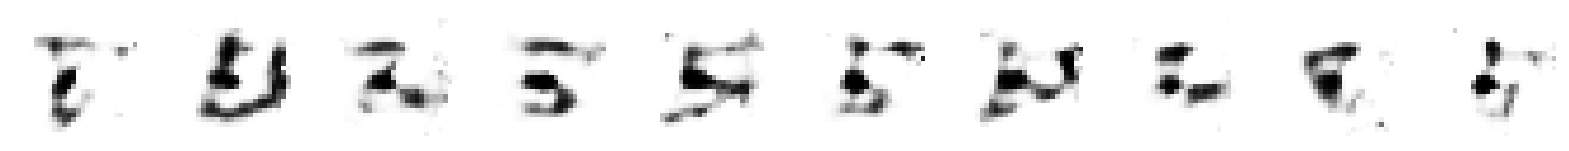

In [12]:
with torch.set_grad_enabled(False):
    number_for_generation=[0,1,2,3,4,5,6,7,8,9]
    inputs = torch.FloatTensor(np.random.randn(10*28*28).reshape(-1,28,28))
    inputs = inputs.to(DEVICE)
    label = one_hot(number_for_generation,9).to(DEVICE)
    outputs = model(inputs,label)
    plot_gallery(outputs.cpu(),28,28,1,10)

# Exploring the latent space using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that works well for the visualization of high-dimensional datasets. We use it to analyze the latent space and plot the results.

In [13]:
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = DataLoader(dataset, batch_size=100, shuffle=True)
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,9).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels

def plot_tsne(net, mode, count, is_cvae=False):
    img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2,random_state=42).fit_transform(latent_vectors)
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

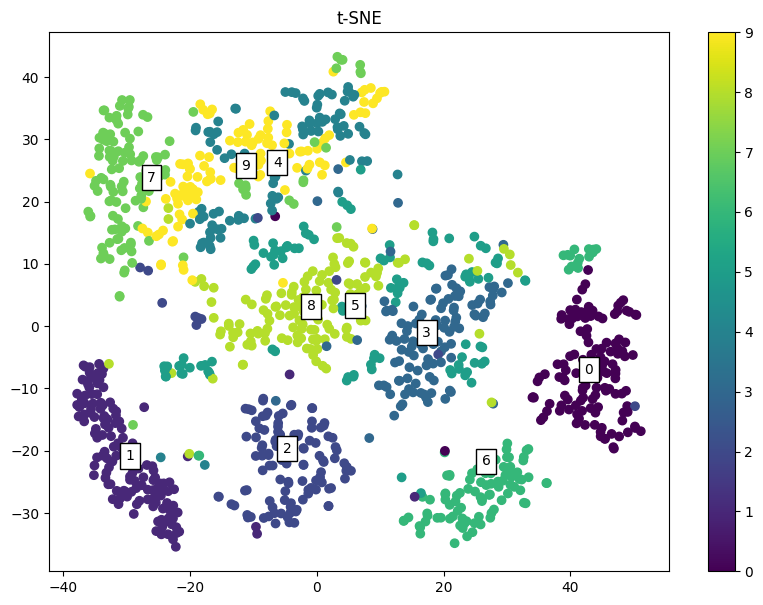

In [14]:
plot_tsne(net=model, mode='dots', count=1000)

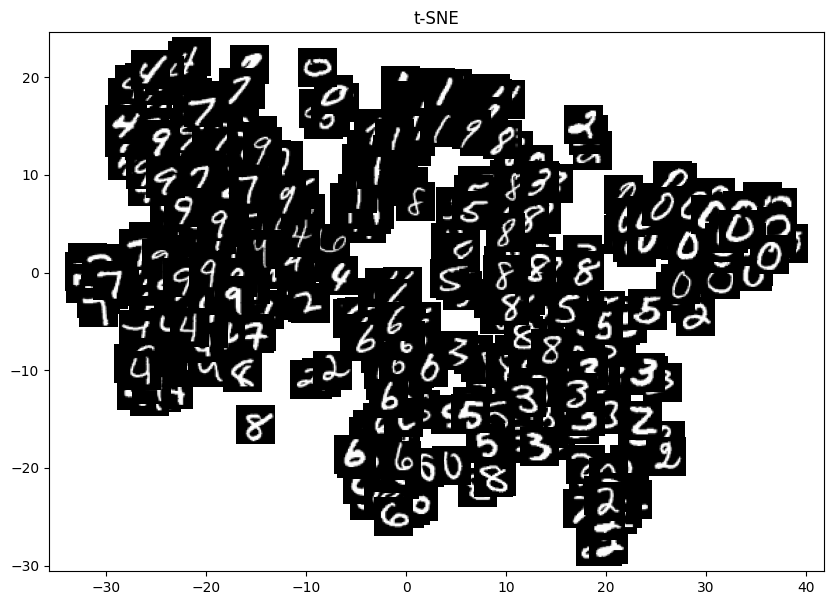

In [15]:
plot_tsne(net=model, mode='imgs', count=300)

# Conditional Variational Autoencoder

In [16]:
class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size=20):
        super(CVAE, self).__init__()
        input_size_with_label = input_size + labels_length
        hidden_size += labels_length
        
        self.fc1 = nn.Linear(input_size_with_label,512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z, labels):
        torch.cat((z, labels), 1)
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        #targets = one_hot(targets,labels_length-1).float().to(DEVICE)
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z, labels)
        return x, mu, logvar

def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=20):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,9).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), 28*28)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

In [17]:
cvae = CVAE(28*28).to(DEVICE)

In [18]:
def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def evaluate(losses, autoencoder, dataloader, flatten=True):
    model = lambda x, y: autoencoder(x, y)[0]    
    loss_sum = []
    inp, out = [],[]
    loss_fn = nn.MSELoss()
    for inputs, labels in dataloader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        if flatten:
            inputs = inputs.view(inputs.size(0), 28*28)

        outputs = model(inputs, labels)
        loss = loss_fn(inputs, outputs)            
        loss_sum.append(loss)
        inp = inputs
        out = outputs

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].detach().cpu(),out[0].detach().cpu()],28,28,1,2)    

    losses.append((sum(loss_sum)/len(loss_sum)).item())

In [19]:
def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=50):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,9).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), 28*28)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

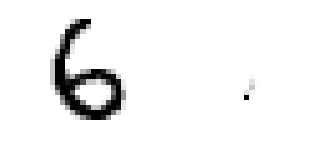

epoch:   2%|▏         | 1/50 [00:13<10:42, 13.11s/it]


Epoch 001 val_loss 0.9148


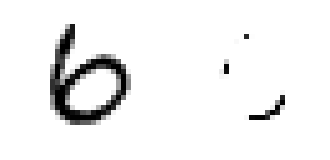

epoch:   4%|▍         | 2/50 [00:26<10:30, 13.13s/it]


Epoch 002 val_loss 0.8937


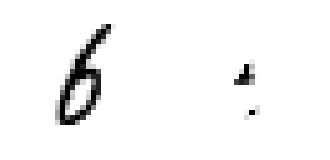

epoch:   6%|▌         | 3/50 [00:39<10:14, 13.07s/it]


Epoch 003 val_loss 0.8841


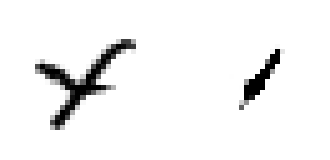

epoch:   8%|▊         | 4/50 [00:52<10:01, 13.07s/it]


Epoch 004 val_loss 0.8735


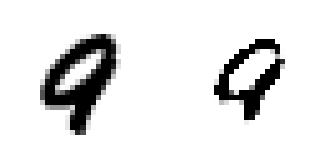

epoch:  10%|█         | 5/50 [01:05<09:48, 13.08s/it]


Epoch 005 val_loss 0.8711


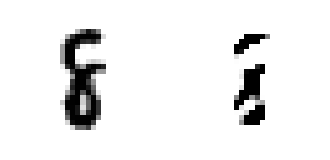

epoch:  12%|█▏        | 6/50 [01:18<09:34, 13.05s/it]


Epoch 006 val_loss 0.8679


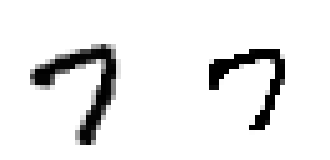

epoch:  14%|█▍        | 7/50 [01:31<09:21, 13.07s/it]


Epoch 007 val_loss 0.8662


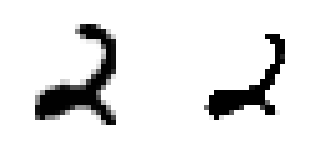

epoch:  16%|█▌        | 8/50 [01:44<09:06, 13.01s/it]


Epoch 008 val_loss 0.8632


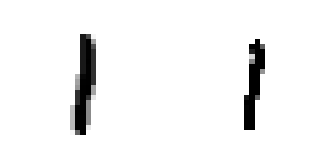

epoch:  18%|█▊        | 9/50 [01:57<08:53, 13.00s/it]


Epoch 009 val_loss 0.8617


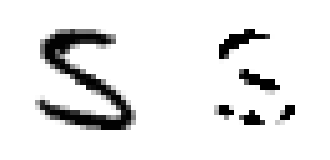

epoch:  20%|██        | 10/50 [02:10<08:40, 13.01s/it]


Epoch 010 val_loss 0.8600


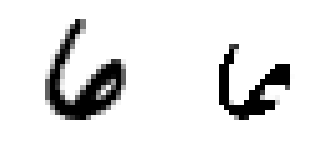

epoch:  22%|██▏       | 11/50 [02:23<08:28, 13.03s/it]


Epoch 011 val_loss 0.8595


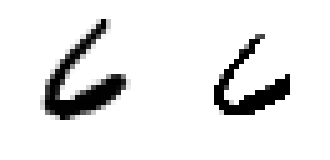

epoch:  24%|██▍       | 12/50 [02:37<08:20, 13.17s/it]


Epoch 012 val_loss 0.8578


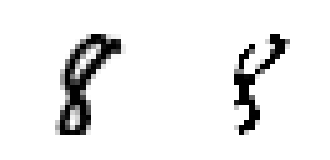

epoch:  26%|██▌       | 13/50 [02:50<08:07, 13.16s/it]


Epoch 013 val_loss 0.8579


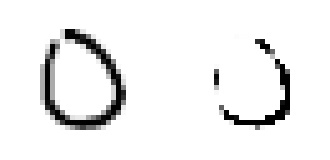

epoch:  28%|██▊       | 14/50 [03:03<07:57, 13.27s/it]


Epoch 014 val_loss 0.8569


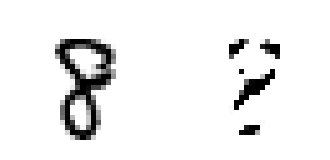

epoch:  30%|███       | 15/50 [03:16<07:39, 13.12s/it]


Epoch 015 val_loss 0.8561


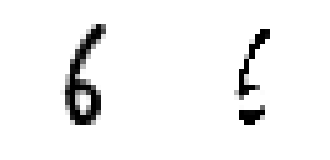

epoch:  32%|███▏      | 16/50 [03:29<07:21, 13.00s/it]


Epoch 016 val_loss 0.8565


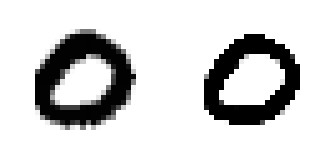

epoch:  34%|███▍      | 17/50 [03:41<07:07, 12.95s/it]


Epoch 017 val_loss 0.8559


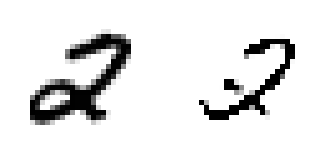

epoch:  36%|███▌      | 18/50 [03:54<06:54, 12.95s/it]


Epoch 018 val_loss 0.8550


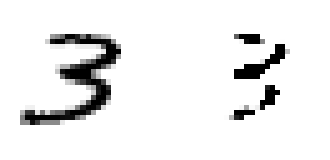

epoch:  38%|███▊      | 19/50 [04:08<06:42, 12.99s/it]


Epoch 019 val_loss 0.8551


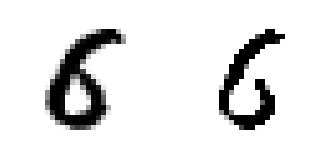

epoch:  40%|████      | 20/50 [04:20<06:28, 12.94s/it]


Epoch 020 val_loss 0.8549


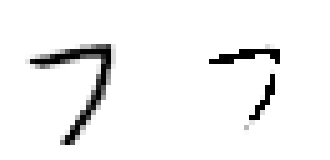

epoch:  42%|████▏     | 21/50 [04:33<06:14, 12.91s/it]


Epoch 021 val_loss 0.8535


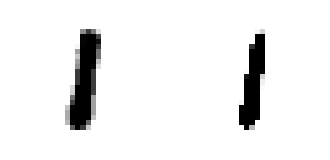

epoch:  44%|████▍     | 22/50 [04:46<06:01, 12.91s/it]


Epoch 022 val_loss 0.8548


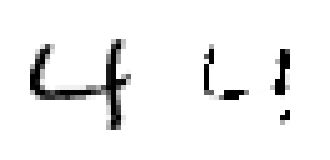

epoch:  46%|████▌     | 23/50 [04:59<05:46, 12.84s/it]


Epoch 023 val_loss 0.8540


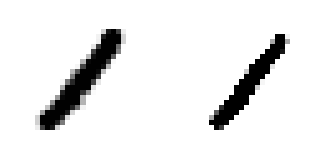

epoch:  48%|████▊     | 24/50 [05:12<05:34, 12.88s/it]


Epoch 024 val_loss 0.8534


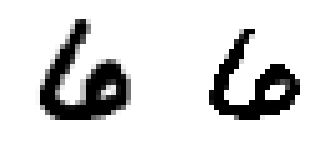

epoch:  50%|█████     | 25/50 [05:24<05:21, 12.84s/it]


Epoch 025 val_loss 0.8535


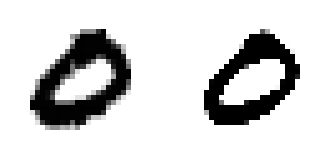

epoch:  52%|█████▏    | 26/50 [05:37<05:08, 12.87s/it]


Epoch 026 val_loss 0.8532


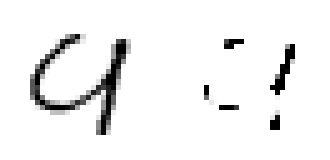

epoch:  54%|█████▍    | 27/50 [05:50<04:56, 12.91s/it]


Epoch 027 val_loss 0.8525


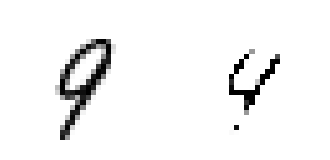

epoch:  56%|█████▌    | 28/50 [06:04<04:47, 13.08s/it]


Epoch 028 val_loss 0.8517


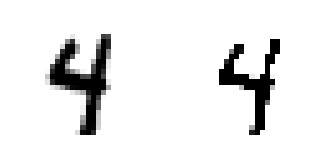

epoch:  58%|█████▊    | 29/50 [06:18<04:43, 13.49s/it]


Epoch 029 val_loss 0.8522


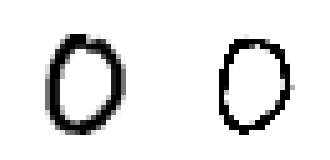

epoch:  60%|██████    | 30/50 [06:32<04:32, 13.64s/it]


Epoch 030 val_loss 0.8523


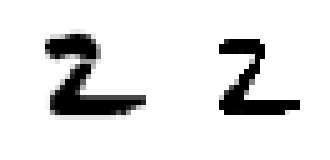

epoch:  62%|██████▏   | 31/50 [06:48<04:28, 14.11s/it]


Epoch 031 val_loss 0.8528


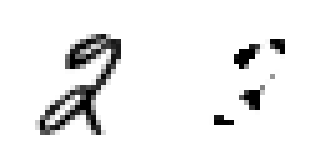

epoch:  64%|██████▍   | 32/50 [07:02<04:15, 14.22s/it]


Epoch 032 val_loss 0.8530


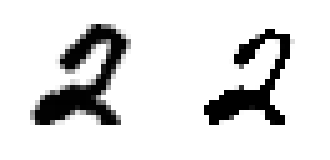

epoch:  66%|██████▌   | 33/50 [07:16<03:59, 14.06s/it]


Epoch 033 val_loss 0.8523


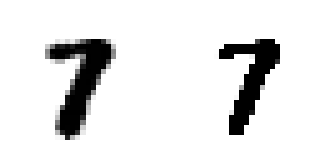

epoch:  68%|██████▊   | 34/50 [07:29<03:42, 13.93s/it]


Epoch 034 val_loss 0.8518


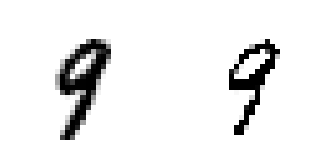

epoch:  70%|███████   | 35/50 [07:43<03:28, 13.91s/it]


Epoch 035 val_loss 0.8513


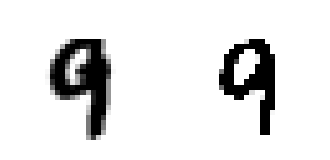

epoch:  72%|███████▏  | 36/50 [07:57<03:12, 13.77s/it]


Epoch 036 val_loss 0.8523


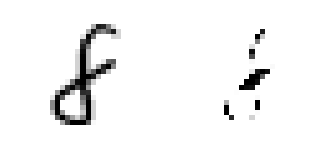

epoch:  74%|███████▍  | 37/50 [08:10<02:56, 13.58s/it]


Epoch 037 val_loss 0.8520


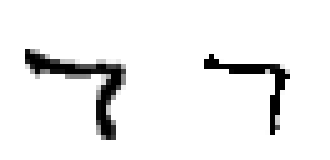

epoch:  76%|███████▌  | 38/50 [08:23<02:41, 13.47s/it]


Epoch 038 val_loss 0.8515


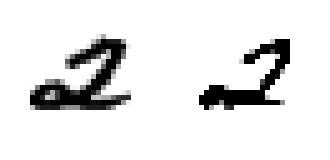

epoch:  78%|███████▊  | 39/50 [08:36<02:26, 13.35s/it]


Epoch 039 val_loss 0.8520


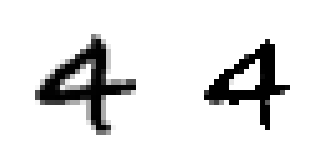

epoch:  80%|████████  | 40/50 [08:49<02:12, 13.26s/it]


Epoch 040 val_loss 0.8513


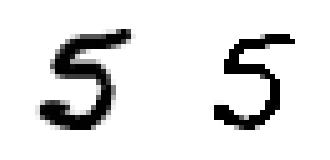

epoch:  82%|████████▏ | 41/50 [09:02<01:58, 13.19s/it]


Epoch 041 val_loss 0.8514


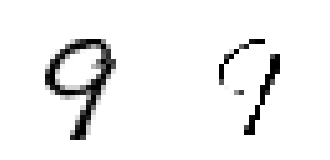

epoch:  84%|████████▍ | 42/50 [09:15<01:45, 13.14s/it]


Epoch 042 val_loss 0.8521


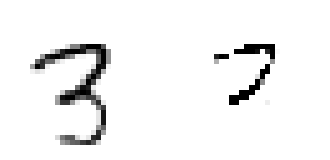

epoch:  86%|████████▌ | 43/50 [09:28<01:32, 13.16s/it]


Epoch 043 val_loss 0.8511


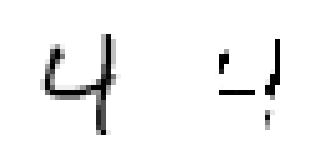

epoch:  88%|████████▊ | 44/50 [09:41<01:18, 13.12s/it]


Epoch 044 val_loss 0.8515


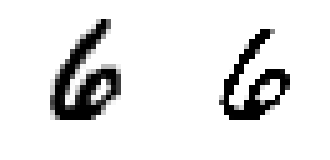

epoch:  90%|█████████ | 45/50 [09:55<01:05, 13.14s/it]


Epoch 045 val_loss 0.8505


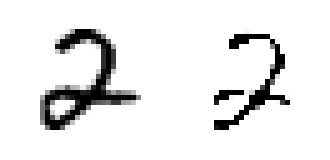

epoch:  92%|█████████▏| 46/50 [10:07<00:52, 13.06s/it]


Epoch 046 val_loss 0.8517


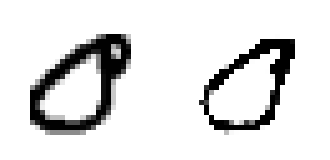

epoch:  94%|█████████▍| 47/50 [10:21<00:39, 13.11s/it]


Epoch 047 val_loss 0.8511


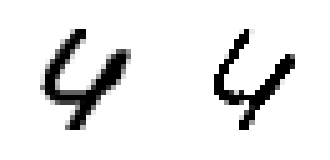

epoch:  96%|█████████▌| 48/50 [10:34<00:26, 13.09s/it]


Epoch 048 val_loss 0.8514


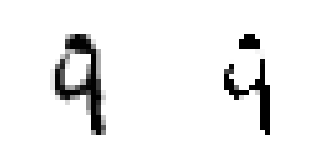

epoch:  98%|█████████▊| 49/50 [10:47<00:13, 13.10s/it]


Epoch 049 val_loss 0.8513


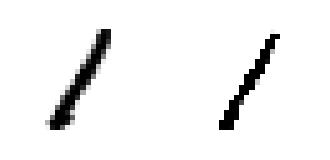

epoch: 100%|██████████| 50/50 [11:00<00:00, 13.22s/it]


Epoch 050 val_loss 0.8506


In [20]:
history = train_cvae(cvae, train_dataset, val_dataset)

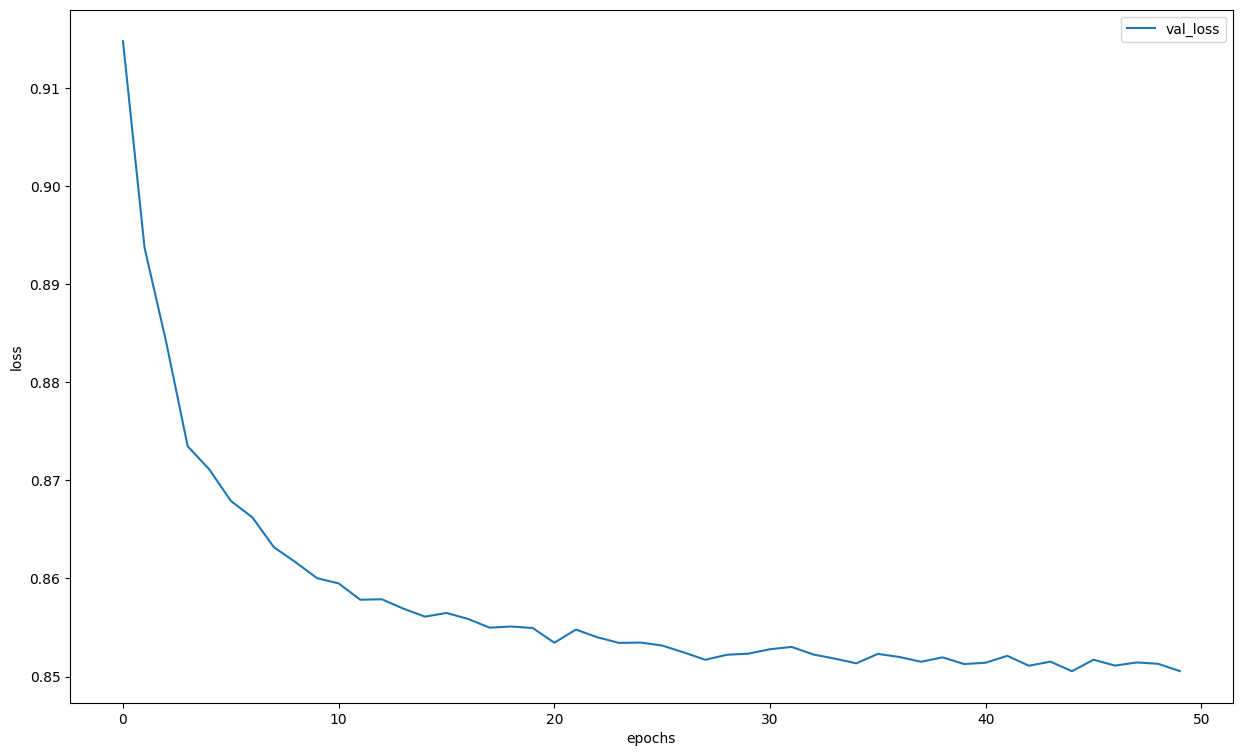

In [21]:
val_loss = history
plt.figure(figsize=(15, 9))
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Plotting CVAE latent space using t-SNE

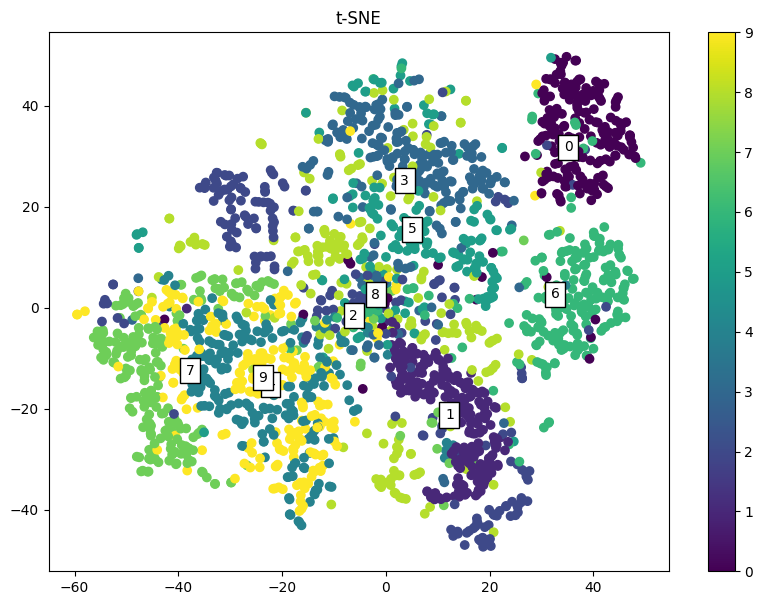

In [22]:
plot_tsne(net=cvae, mode='dots', count=2000, is_cvae=True)

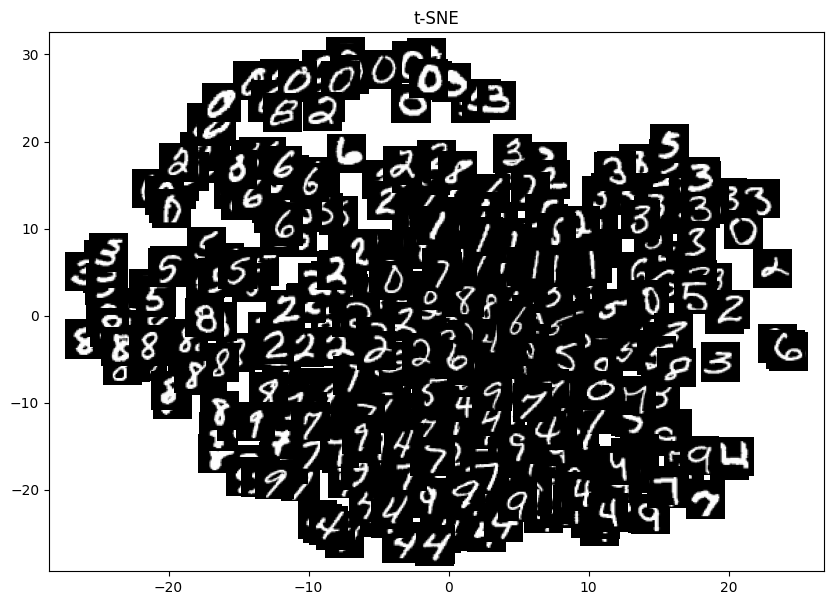

In [23]:
plot_tsne(net=cvae, mode='imgs', count=300, is_cvae=True)

# Conclusion


By concurrently optimizing both the reconstruction loss and KL divergence loss, we achieve the creation of a latent space that, on a local scale, retains the similarity of neighboring encodings through clustering. However, on a global scale, this space becomes densely concentrated near the origin (compare the axes with the original).

Example:

![https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif](https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif)